### Импортируем библиотеки

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from sklearn.compose import TransformedTargetRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Загружаем данные

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/Basic_ML_Alg/main/cars_moldova_clean.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)']

# Визуализация

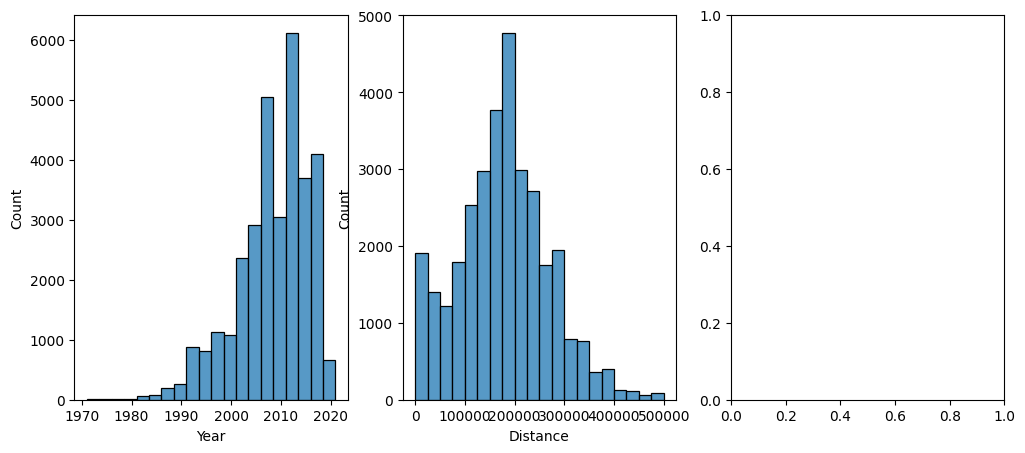

In [ ]:
width = 3 # количество столбцов в "полотне", на котором отображаются графики
height = 1 # количество строк в "полотне", на котором отображаются графики

# создаем "полотно", на котором будут отображены графики
fig, ax = plt.subplots(nrows=height, ncols=width, figsize=(12,5))

for idx, column_name in enumerate(num_columns[:-1]): # перебираем все числовые данные
    plt.subplot(height,width, idx+1) #берем конкретную ячейку в "полотне"
    # отображаем с помощью библиотеки seaborn
    sns.histplot(data=DF,   # используемый датафрейм
            x=column_name,  # отрисовываемая переменная
            bins = 20);     # количество столбцов гистограммы

Наблюдаются выбросы у признака 'year'  
'Distance' и 'Engine_capacity(cm3)' выглядят нормально распределенными

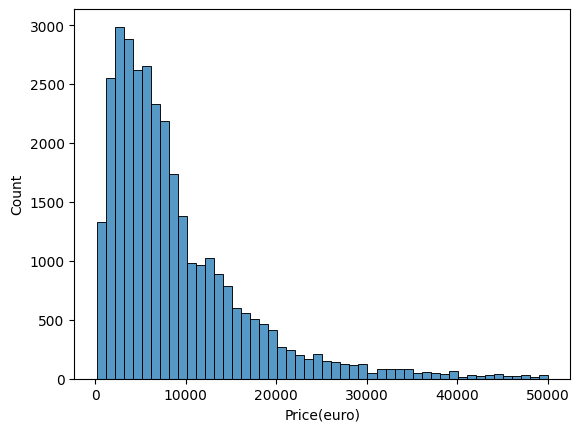

In [ ]:
#Гистограмма распределения цены (числовой признак)
sns.histplot(data=DF, x='Price(euro)', bins = 50);

<Axes: xlabel='Year', ylabel='Price(euro)'>

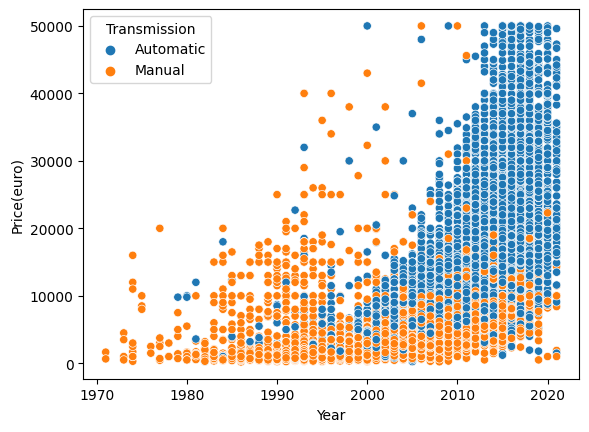

In [ ]:
# Скатерограмма для сравнения распределений года и цены по трансмиссии (категориальный признак)
sns.scatterplot(data=DF, x='Year', y='Price(euro)', hue='Transmission')

<Axes: xlabel='Engine_capacity(cm3)', ylabel='Price(euro)'>

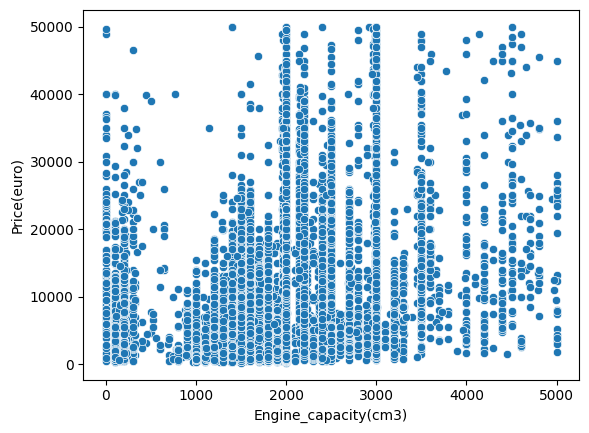

In [ ]:
# Скатерограмма для анализа созависимости цены и объема двигателя (числовые признаки)
sns.scatterplot(data=DF, x='Engine_capacity(cm3)', y='Price(euro)')

# Обработка данных

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [ ]:
num_pipe_all = Pipeline([
    ('power', PowerTransformer()),
    (('scaler', StandardScaler())),
    ('minmax_scaler', MinMaxScaler())

])


cat_pipe_all = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OrdinalEncoder()),
    ('minmax_scaler', MinMaxScaler())
])



# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_columns', num_pipe_all, num_columns),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_columns', num_pipe_all, num_columns),
    ('cat_columns', cat_pipe_all, cat_columns),

])

In [ ]:
preprocessors_all

ColumnTransformer(transformers=[('num_columns',
                                 Pipeline(steps=[('power', PowerTransformer()),
                                                 ('scaler', StandardScaler()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Year', 'Distance', 'Engine_capacity(cm3)']),
                                ('cat_columns',
                                 Pipeline(steps=[('replace_rare',
                                                  RareGrouper(threshold=0.001)),
                                                 ('encoder', OrdinalEncoder()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_columns,
                    cat_columns])

# Линейная Регрессия

In [ ]:
from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

Считываем данные, разбиваем на тестовую и тренировочную

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission
2215,BMW,X5,2010,Universal,150000.0,3000.0,Petrol,Automatic
24043,Renault,Kangoo,2004,Minivan,198500.0,1499.0,Diesel,Manual
25744,Volkswagen,Phaeton,2007,Sedan,240000.0,300.0,Diesel,Automatic
16217,Skoda,Kodiaq,2018,SUV,24000.0,2000.0,Petrol,Automatic
8019,Mercedes,E Class,2014,Sedan,173000.0,2148.0,Diesel,Automatic
...,...,...,...,...,...,...,...,...
29802,Opel,Astra,2012,Universal,180000.0,1300.0,Diesel,Manual
5390,Skoda,Octavia,2006,Universal,250000.0,1900.0,Diesel,Manual
860,Toyota,Auris,2015,Hatchback,179713.0,1400.0,Diesel,Manual
15795,Dacia,Logan,2006,Sedan,300000.0,1396.0,Metan/Propan,Manual


### Модель с использованием только числовых данных


Преобразуем данные

In [ ]:
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

Обучаем модель

In [ ]:
# Создаем объект класса
model = SGDRegressor(random_state = 42)

# Обучаем модель
model.fit(X_train_prep, y_train);

вытаскивание коэффициентов из модели


In [ ]:
def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_
    return B0, B

написание модели

In [ ]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

визуализации весов в виде столбчатых диаграмм

In [ ]:
def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов
    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

 Напишем уравнение модели

In [ ]:
B0, B = get_coefs(model)
features_names = list(columns_num)
print_model(B0,B,features_names)

Решение
-15774.303+27194.23*Year-5877.54*Distance+22400.95*Engine_capacity(cm3)


 Визуализируем веса в виде столбчатых диаграмм

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

 Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5364
r2 на валидационной выборке: 0.5285
mse на тренировочной выборке: 28193388.0376
mse на валидационной выборке: 29685250.1264
rmse на тренировочной выборке: 5309.7446
rmse на валидационной выборке: 5448.4172


 Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.111377,0.001911,0.538700,-2.731440e+07,-3538.569855,-38388.852033
1,0.108477,0.001889,0.552265,-2.894892e+07,-3664.638155,-42128.411868
2,0.080698,0.001904,0.551230,-2.755113e+07,-3481.746111,-39906.481999
3,0.074695,0.001868,0.510882,-2.921276e+07,-3692.432911,-30290.117729
4,0.099547,0.001947,0.523428,-2.791021e+07,-3467.075403,-42307.925538




test_R2      5.353010e-01
test_-MSE   -2.818748e+07
test_-MAE   -3.568892e+03
test_-Max   -3.860436e+04
dtype: float64


### Визуализация ошибок от scikit-learn

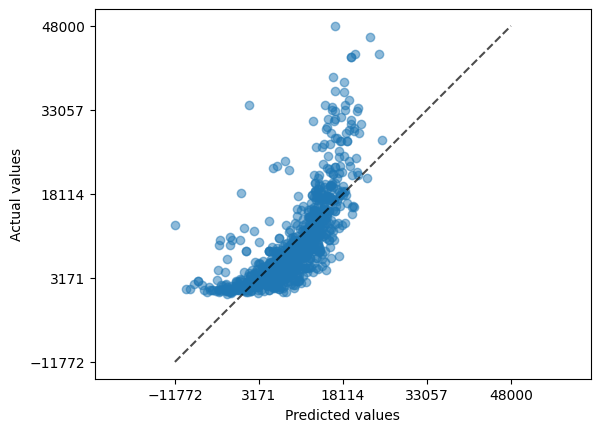

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* используя только 3 числовых признака можно с достаточно большой погрешностью предсказывать пробег

* есть проблемы предсказания как низких значений пробега, так и высоких

* модель выглядит "логично": рост года выпуска и объем двигателя положительно сказывается на цене, рост цены - отрицательно



 Объединяем Pipeline Предобработки и Модель

In [ ]:
pipe_num = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', SGDRegressor(random_state = 42))
])

Чтобы "обратиться" к части Pipeline - достаточно помнить "имя"

In [ ]:
pipe_num['preprocessors']

ColumnTransformer(transformers=[('num_columns',
                                 Pipeline(steps=[('power', PowerTransformer()),
                                                 ('scaler', StandardScaler()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Year', 'Distance', 'Engine_capacity(cm3)'])])

In [ ]:
pipe_num['model']

SGDRegressor(random_state=42)

Так же обучаем через .fit()

In [ ]:
pipe_num.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_columns',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity(cm3)'])])),
                ('model', SGDRegressor(random_state=42))])

In [ ]:
B0, B = get_coefs(pipe_num['model'])
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
-15774.303+27194.23*Year-5877.54*Distance+22400.95*Engine_capacity(cm3)


In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5364
r2 на валидационной выборке: 0.5285
mse на тренировочной выборке: 28193388.0376
mse на валидационной выборке: 29685250.1264
rmse на тренировочной выборке: 5309.7446
rmse на валидационной выборке: 5448.4172


In [ ]:
cross_validation (X_train, y_train,
                  pipe_num,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.370010,0.009608,0.538437,-2.732999e+07,-3539.700101,-38418.324674
1,0.330633,0.008036,0.552433,-2.893804e+07,-3663.752890,-42132.067780
2,0.289532,0.007616,0.550915,-2.757044e+07,-3483.235373,-39906.482689
3,0.305927,0.007325,0.510966,-2.920774e+07,-3692.101218,-30289.227624
4,0.305367,0.007419,0.522799,-2.794706e+07,-3469.897589,-42298.114144




test_R2      5.351100e-01
test_-MSE   -2.819865e+07
test_-MAE   -3.569737e+03
test_-Max   -3.860884e+04
dtype: float64


## Влияние нормализации целевой переменной

In [ ]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_columns',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity(cm3)'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
B0, B = get_coefs(pipe_num_transform['model'].regressor_)
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
-3.612+4.25*Year-0.26*Distance+2.30*Engine_capacity(cm3)


In [ ]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.6065
r2 на валидационной выборке: 0.5986
mse на тренировочной выборке: 23926629.5435
mse на валидационной выборке: 25270013.9597
rmse на тренировочной выборке: 4891.4854
rmse на валидационной выборке: 5026.9289


In [ ]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.357059,0.008909,0.613080,-2.291024e+07,-2845.659876,-38473.711884
1,0.282193,0.008177,0.627673,-2.407330e+07,-2898.995148,-38567.159083
2,0.273759,0.007811,0.622249,-2.319107e+07,-2848.889242,-39716.865639
3,0.290709,0.006007,0.593422,-2.428301e+07,-2947.451427,-31799.189051
4,0.185138,0.006198,0.585644,-2.426656e+07,-2846.559971,-42168.122051




test_R2      6.084137e-01
test_-MSE   -2.374484e+07
test_-MAE   -2.877511e+03
test_-Max   -3.814501e+04
dtype: float64


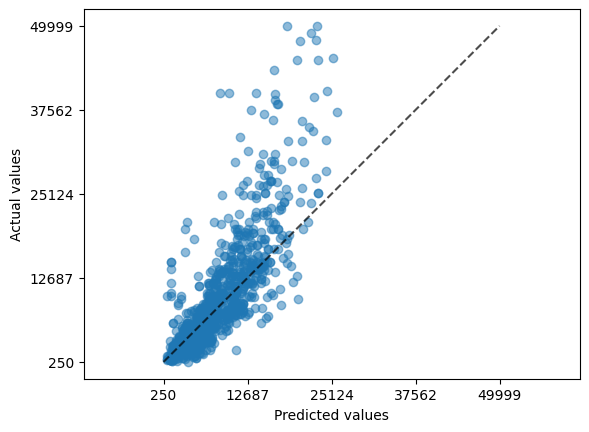

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Как видим, нормализация целевой переменной положительно сказалась на нашей модели

## Добавим категориальные признаки

In [ ]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_all_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_columns',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity(cm3)']),
                                                 ('cat_columns',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([
                    num_columns,
                    cat_columns])

In [ ]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
-2.155+3.38*Year-0.28*Distance+1.33*Engine_capacity(cm3)-0.07*Make+0.04*Model-0.09*Style-0.20*Fuel_type-0.57*Transmission


In [ ]:
def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

In [ ]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 0.08, width = 1800)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.6379
r2 на валидационной выборке: 0.6325
mse на тренировочной выборке: 22019839.9351
mse на валидационной выборке: 23138807.5264
rmse на тренировочной выборке: 4692.5302
rmse на валидационной выборке: 4810.2814


In [ ]:
cross_validation (X_train, y_train,
                  pipe_all_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.338784,0.020247,0.644090,-2.107407e+07,-2735.174586,-33026.716681
1,0.329057,0.023324,0.652810,-2.244804e+07,-2770.339214,-38488.727669
2,0.315020,0.020065,0.649943,-2.149089e+07,-2774.522299,-39909.145022
3,0.331097,0.019468,0.626167,-2.232729e+07,-2828.215083,-31086.323026
4,0.333872,0.021625,0.620671,-2.221524e+07,-2741.806794,-39424.680821




test_R2      6.387362e-01
test_-MSE   -2.191111e+07
test_-MAE   -2.770012e+03
test_-Max   -3.638712e+04
dtype: float64


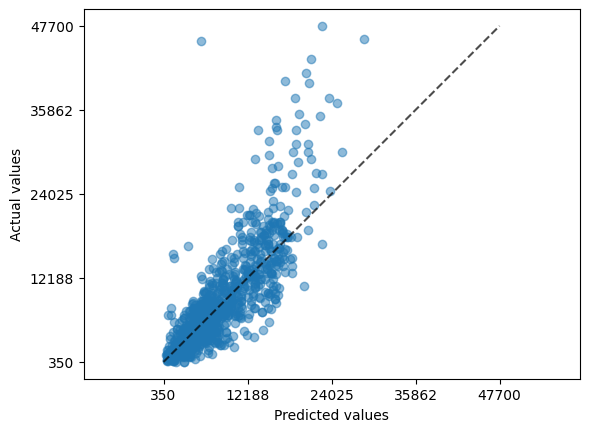

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* добавление категориальных признаков улучшает результаты линейной модели (метрика r2 на кроссвалидации)

* предсказание цены автомобилей немного улучшилось


# Сделаем feature engineering и попробуем улучшить модель

In [ ]:
current_year = 2022 # Последний год в датасете
DF['Age'] = 2021 - DF['Year'] # Возраст машины

DF['Price_per_km'] = DF['Price(euro)'] / DF['Distance'] # Цена на каждый проеденный км
DF['Mileage_per_Year'] = DF['Distance'] / (current_year - DF['Year']) # Проеденное расстояние за год

new_columns = ['Price_per_km', 'Mileage_per_Year'] # Новые признаки
num_columns += new_columns # Добавляем их к старым

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_columns', num_pipe_all, num_columns),
    ('cat_columns', cat_pipe_all, cat_columns),

])

In [ ]:
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42) # Разбиваем на трейн и валид новую выборку

In [ ]:
# Проделываем все тоже самое
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [ ]:
pipe_all_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_columns',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Year', 'Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price_per_km',
                                                   'Mileage_per_Year',
                                                   'Price_per_km',
                                                   'Mileage_per_Year',
                                                   'Price_per_km',
                                                   'Mileage_per_Year']),
                                                 ('cat_columns',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.001)),
                                                                  ('encoder',
                                                                   OrdinalEncoder()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([
                    num_columns,
                    cat_columns])

In [ ]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
-2.855+1.67*Year+1.35*Distance+0.64*Engine_capacity(cm3)+0.82*Price_per_km+1.01*Mileage_per_Year+0.82*Price_per_km+1.01*Mileage_per_Year+0.82*Price_per_km+1.01*Mileage_per_Year-0.00*Make-0.02*Model-0.11*Style-0.13*Fuel_type-0.33*Transmission


Модификация функции для отрисовки весов


In [ ]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 0.08, width = 1800)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.8263
r2 на валидационной выборке: 0.8290
mse на тренировочной выборке: 10562618.3674
mse на валидационной выборке: 10766886.1927
rmse на тренировочной выборке: 3250.0182
rmse на валидационной выборке: 3281.2934


In [ ]:
cross_validation (X_train, y_train,
                  pipe_all_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.479938,0.020678,0.832232,-9.933862e+06,-1919.517248,-28709.749869
1,0.537697,0.020745,0.847645,-9.850702e+06,-1900.872562,-32285.142034
2,0.531777,0.027711,0.815271,-1.134095e+07,-1950.399437,-31174.537424
3,0.473117,0.021461,0.824453,-1.048461e+07,-2015.935702,-25109.615010
4,0.738822,0.042284,0.825321,-1.023000e+07,-1912.872260,-33868.603912




test_R2      8.289845e-01
test_-MSE   -1.036802e+07
test_-MAE   -1.939919e+03
test_-Max   -3.022953e+04
dtype: float64


Качество модели (R2) значительно улучшилось

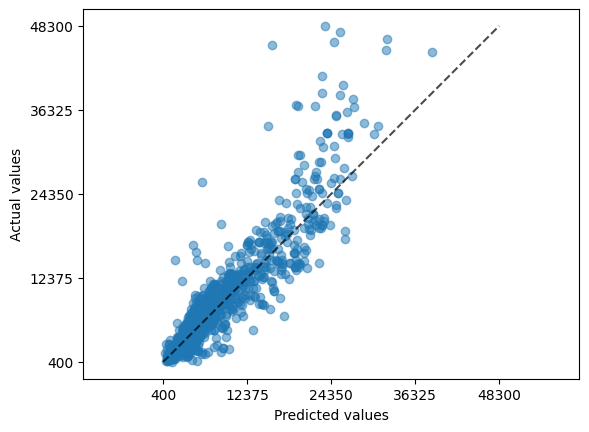

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

С добавлением новых признаков, качество модели значительно улучшилась